<a href="https://colab.research.google.com/github/SanskarJadhav/DeepLearning/blob/main/LSTM_Advanced_Flight_Trajectory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Final Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [2]:
from glob import glob
csvs = glob('/content/*.csv')
csv_list = [csv[:-5] for csv in csvs]
csv_list.sort()

In [3]:
datelist = []
for i in csv_list:
  daynum = i[9:11]
  datelist.append(int(daynum))
print(datelist)

[12, 13, 14, 15, 16]


In [13]:
dataframelist = []
for i in csv_list:
  df_new = pd.read_csv(i+'1.csv')
  #df_new = df_new.dropna(subset=['Time (IST)']).reset_index(drop=True)
  daylist = np.array(df_new['Time (IST)'])
  count1 = df_new['Time (IST)'].first_valid_index()
  count2 = df_new['Time (IST)'].last_valid_index()
  strday = daylist[count1][:3]
  df_new['date_time'] = np.nan
  for j in range(count1, count2+1):
    day2 = daylist[j][:3]
    if(strday==day2):
      df_new['date_time'][j] = i[9:] + daylist[j][3:]
    else:
      df_new['date_time'][j] = str(int(i[9:11]) + 1) + i[11:] + daylist[j][3:]
  dataframelist.append(df_new)

In [19]:
import datetime
for df in dataframelist:
  df['date_time'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M:%S')
  count1 = df['date_time'].first_valid_index()
  count2 = df['date_time'].last_valid_index()
  for i in range(count1-1,-1,-1):
    df['date_time'][i] = df['date_time'][i+1] - datetime.timedelta(seconds=1)
  for i in range(count2+1, df.shape[0]):
    df['date_time'][i] = df['date_time'][i-1] + datetime.timedelta(seconds=1)
  df['day'] = df['date_time'].apply(lambda x: x.day)
  df['hour'] = df['date_time'].apply(lambda x: x.hour)
  df['minute'] = df['date_time'].apply(lambda x: x.minute)
  df['second'] = df['date_time'].apply(lambda x: x.second)
  print(df.head())

  Time (IST)  Latitude  Longitude  Course      kts     mph   meters   Rate  \
0        NaN   17.2281    78.4155 88.0000 172.0000  0.0000 626.4066 0.0000   
1        NaN   17.2281    78.4155 88.0000 172.0000 19.8000 626.4066 0.0000   
2        NaN   17.2281    78.4156 88.0000 172.0000 39.6000 626.4066 0.0000   
3        NaN   17.2281    78.4159 88.0000 172.0000 59.4000 626.4066 0.0000   
4        NaN   17.2281    78.4161 88.0000 172.0000 79.2000 626.4066 0.0000   

  Reporting Facility  Time Diff     m/s  Dist from lp   tilt  \
0                NaN     0.0000  0.0000        0.0000 0.0000   
1                NaN     1.0000  8.8000        4.4000 0.0000   
2                NaN     1.0000 17.6000       13.2000 0.0000   
3                NaN     1.0000 26.4000       22.0000 0.0000   
4                NaN     1.0000 35.2000       30.8000 0.0000   

            date_time  day  hour  minute  second  
0 2023-03-12 22:46:40   12    22      46      40  
1 2023-03-12 22:46:41   12    22      46    

## For Latitude

In [20]:
df_update = dataframelist[0].loc[:,['date_time','Latitude', 'day', 'hour','minute','second']]
for df in dataframelist[1:]:
  df_lat=df.loc[:,['date_time','Latitude', 'day', 'hour','minute','second']]
  df_update = pd.concat([df_update, df_lat], axis=0)
df_update

,date_time,Latitude,day,hour,minute,second
0,2023-03-12 22:46:40,17.2281,12,22,46,40
1,2023-03-12 22:46:41,17.2281,12,22,46,41
2,2023-03-12 22:46:42,17.2281,12,22,46,42
3,2023-03-12 22:46:43,17.2281,12,22,46,43
4,2023-03-12 22:46:44,17.2281,12,22,46,44
...,...,...,...,...,...,...
293,2023-03-17 00:09:57,19.0887,17,0,9,57
294,2023-03-17 00:09:58,19.0887,17,0,9,58
295,2023-03-17 00:09:59,19.0887,17,0,9,59
296,2023-03-17 00:10:00,19.0887,17,0,10,0


In [21]:
stat, p = stats.normaltest(df_update.Latitude)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=6334.820, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -1.6723528035925785
Skewness of normal distribution: 0.2661915866625705


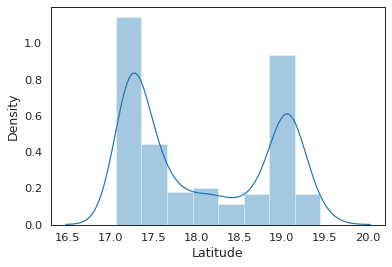

In [22]:
sns.distplot(df_update.Latitude);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df_update.Latitude)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df_update.Latitude)))

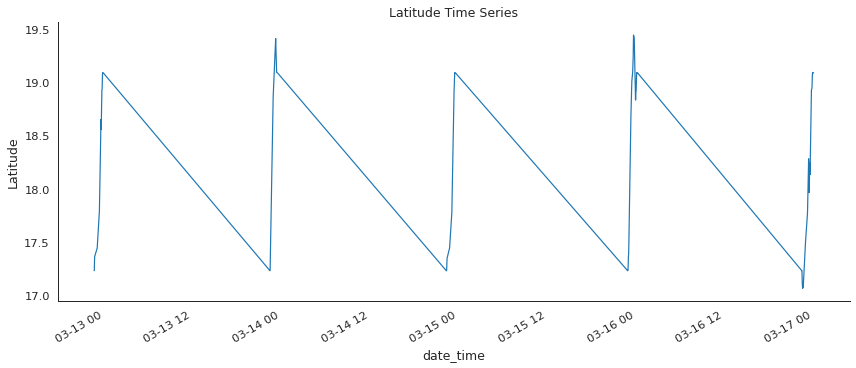

In [23]:
dfspec=df_update.loc[:,['date_time','Latitude']]
dfspec.set_index('date_time',inplace=True)
dfspec.plot(figsize=(12,5))
plt.ylabel('Latitude')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Latitude Time Series')
sns.despine(top=True)
plt.show();

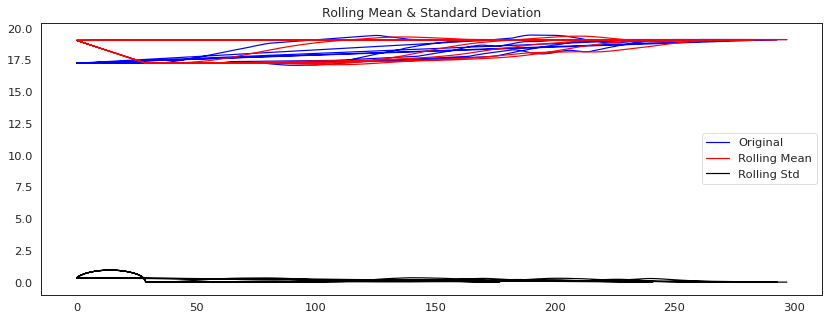

<Results of Dickey-Fuller Test>
Test Statistic                  -2.2528
p-value                          0.1877
#Lags Used                       0.0000
Number of Observations Used   1295.0000
Critical Value (1%)             -3.4354
Critical Value (5%)             -2.8638
Critical Value (10%)            -2.5680
dtype: float64


In [24]:
df2=df_update.copy()
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Latitude.dropna())

In [25]:
dataset = df_update.Latitude.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
test_size = dataframelist[-1].shape[0]
train_size = len(dataset) - test_size
train, test = dataset[:train_size,:], dataset[train_size:,:]

def create_dataset(dataset, look_back, look_ahead):
    X, Y = [], []
    for i in range(len(dataset)-look_back-look_ahead):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back + look_ahead - 1, 0])
    return np.array(X), np.array(Y)
    
look_back = 5
look_ahead = 1
X_train, Y_train = create_dataset(train, look_back, look_ahead)
X_test, Y_test = create_dataset(test, look_back, look_ahead)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [26]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1, shuffle=False)

model.summary()

Epoch 1/15
31/31 [==============================] - 3s 23ms/step - loss: 0.1383 - val_loss: 0.0280
Epoch 2/15
31/31 [==============================] - 0s 6ms/step - loss: 0.0157 - val_loss: 0.0088
Epoch 3/15
31/31 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0050
Epoch 4/15
31/31 [==============================] - 0s 5ms/step - loss: 0.0092 - val_loss: 0.0030
Epoch 5/15
31/31 [==============================] - 0s 5ms/step - loss: 0.0071 - val_loss: 0.0018
Epoch 6/15
31/31 [==============================] - 0s 5ms/step - loss: 0.0067 - val_loss: 0.0012
Epoch 7/15
31/31 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 9.3261e-04
Epoch 8/15
31/31 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 8.5158e-04
Epoch 9/15
31/31 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 7.1809e-04
Epoch 10/15
31/31 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 6.8228e-04
Ep

In [27]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

10/10 [==============================] - 1s 2ms/step
Train Mean Absolute Error: 0.0604341328529477
Train Root Mean Squared Error: 0.15357616652367226
Test Mean Absolute Error: 0.04784226233326322
Test Root Mean Squared Error: 0.06099176652275137


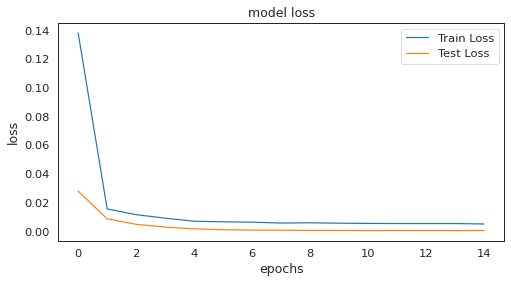

In [28]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

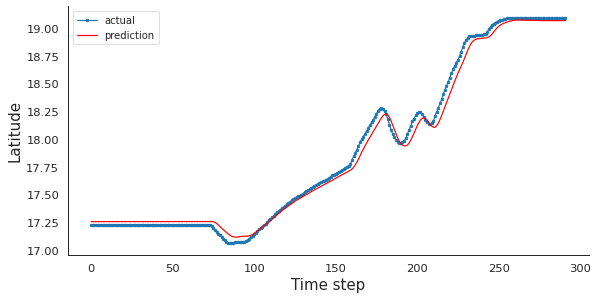

In [29]:
aa=[x for x in range(Y_test.shape[1])]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Latitude', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show();

## For Longitude

In [30]:
df_update = dataframelist[0].loc[:,['date_time','Longitude', 'day', 'hour','minute','second']]
for df in dataframelist[1:]:
  df_long=df.loc[:,['date_time','Longitude', 'day', 'hour','minute','second']]
  df_update = pd.concat([df_update, df_long], axis=0)
df_update

,date_time,Longitude,day,hour,minute,second
0,2023-03-12 22:46:40,78.4155,12,22,46,40
1,2023-03-12 22:46:41,78.4155,12,22,46,41
2,2023-03-12 22:46:42,78.4156,12,22,46,42
3,2023-03-12 22:46:43,78.4159,12,22,46,43
4,2023-03-12 22:46:44,78.4161,12,22,46,44
...,...,...,...,...,...,...
293,2023-03-17 00:09:57,72.8676,17,0,9,57
294,2023-03-17 00:09:58,72.8674,17,0,9,58
295,2023-03-17 00:09:59,72.8672,17,0,9,59
296,2023-03-17 00:10:00,72.8671,17,0,10,0


In [31]:
stat, p = stats.normaltest(df_update.Longitude)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=5783.679, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -1.7487182937002503
Skewness of normal distribution: 0.013708862188368743


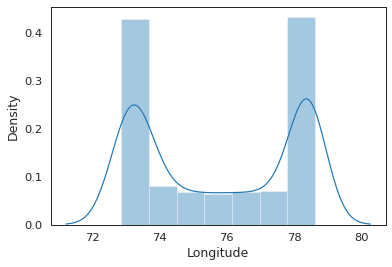

In [32]:
sns.distplot(df_update.Longitude);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df_update.Longitude)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df_update.Longitude)))

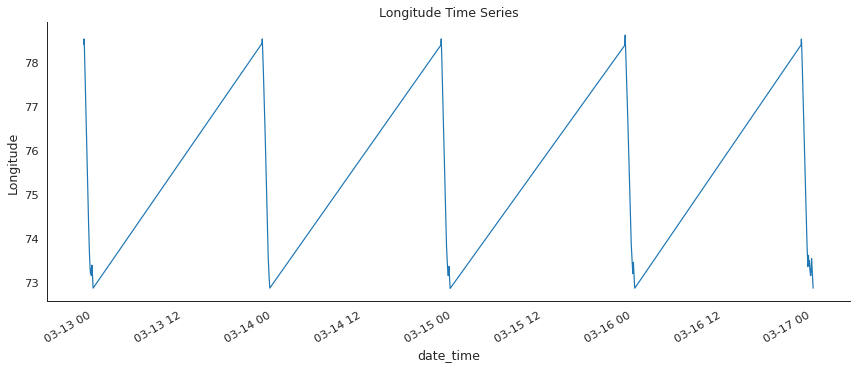

In [33]:
dfspec=df_update.loc[:,['date_time','Longitude']]
dfspec.set_index('date_time',inplace=True)
dfspec.plot(figsize=(12,5))
plt.ylabel('Longitude')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Longitude Time Series')
sns.despine(top=True)
plt.show();

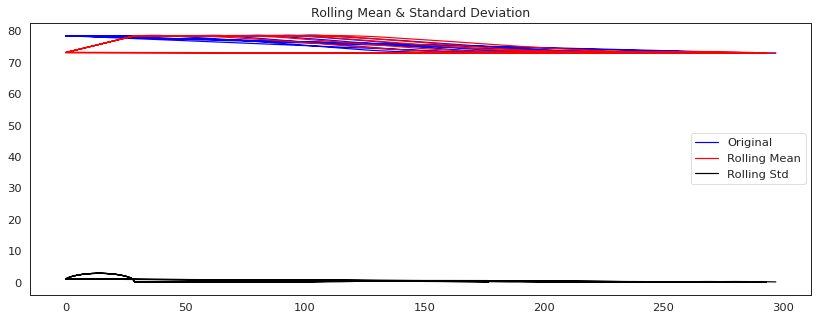

<Results of Dickey-Fuller Test>
Test Statistic                  -2.3946
p-value                          0.1433
#Lags Used                       0.0000
Number of Observations Used   1295.0000
Critical Value (1%)             -3.4354
Critical Value (5%)             -2.8638
Critical Value (10%)            -2.5680
dtype: float64


In [34]:
df2=df_update.copy()
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Longitude)

In [35]:
dataset = df_update.Longitude.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
test_size = dataframelist[-1].shape[0]
train_size = len(dataset) - test_size
train, test = dataset[:train_size,:], dataset[train_size:,:]

def create_dataset(dataset, look_back, look_ahead):
    X, Y = [], []
    for i in range(len(dataset)-look_back-look_ahead):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back + look_ahead - 1, 0])
    return np.array(X), np.array(Y)
    
look_back = 5
look_ahead = 1
X_train, Y_train = create_dataset(train, look_back, look_ahead)
X_test, Y_test = create_dataset(test, look_back, look_ahead)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [36]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1, shuffle=False)

model.summary()

Epoch 1/15
31/31 [==============================] - 3s 32ms/step - loss: 0.2679 - val_loss: 0.0677
Epoch 2/15
31/31 [==============================] - 0s 8ms/step - loss: 0.0368 - val_loss: 0.0101
Epoch 3/15
31/31 [==============================] - 0s 9ms/step - loss: 0.0140 - val_loss: 0.0070
Epoch 4/15
31/31 [==============================] - 0s 9ms/step - loss: 0.0117 - val_loss: 0.0047
Epoch 5/15
31/31 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.0031
Epoch 6/15
31/31 [==============================] - 0s 9ms/step - loss: 0.0089 - val_loss: 0.0019
Epoch 7/15
31/31 [==============================] - 0s 10ms/step - loss: 0.0082 - val_loss: 0.0012
Epoch 8/15
31/31 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 7.7224e-04
Epoch 9/15
31/31 [==============================] - 0s 5ms/step - loss: 0.0076 - val_loss: 4.7030e-04
Epoch 10/15
31/31 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 3.6022e-04
Epoch

In [37]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

10/10 [==============================] - 0s 2ms/step
Train Mean Absolute Error: 0.11430858366660565
Train Root Mean Squared Error: 0.42561594272440484
Test Mean Absolute Error: 0.06590822578098841
Test Root Mean Squared Error: 0.0802806538289496


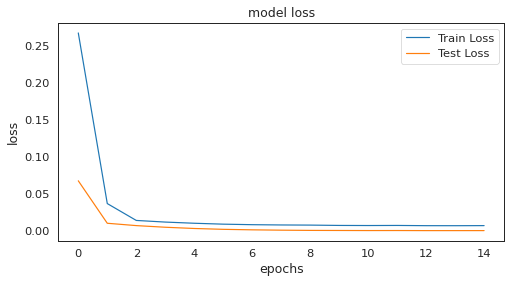

In [38]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

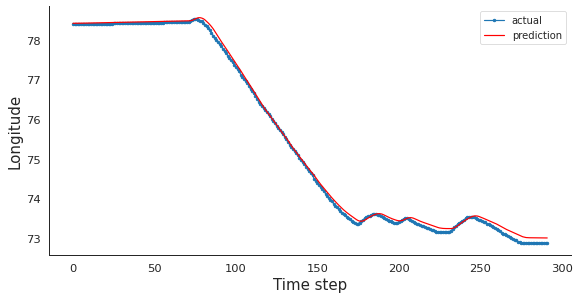

In [39]:
aa=[x for x in range(Y_test.shape[1])]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:][:,0], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Longitude', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show();

## Altitude

In [40]:
df_update = dataframelist[0].loc[:,['date_time','meters', 'day', 'hour','minute','second']]
for df in dataframelist[1:]:
  df_alt=df.loc[:,['date_time','meters', 'day', 'hour','minute','second']]
  df_update = pd.concat([df_update, df_alt], axis=0)
df_update

,date_time,meters,day,hour,minute,second
0,2023-03-12 22:46:40,626.4066,12,22,46,40
1,2023-03-12 22:46:41,626.4066,12,22,46,41
2,2023-03-12 22:46:42,626.4066,12,22,46,42
3,2023-03-12 22:46:43,626.4066,12,22,46,43
4,2023-03-12 22:46:44,626.4066,12,22,46,44
...,...,...,...,...,...,...
293,2023-03-17 00:09:57,20.8588,17,0,9,57
294,2023-03-17 00:09:58,20.8588,17,0,9,58
295,2023-03-17 00:09:59,20.8588,17,0,9,59
296,2023-03-17 00:10:00,20.8588,17,0,10,0


In [41]:
stat, p = stats.normaltest(df_update.meters)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=130251.514, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -1.3597002491065115
Skewness of normal distribution: 0.5308966628337567


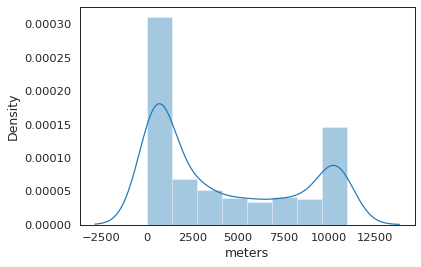

In [42]:
sns.distplot(df_update.meters);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df_update.meters)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df_update.meters)))

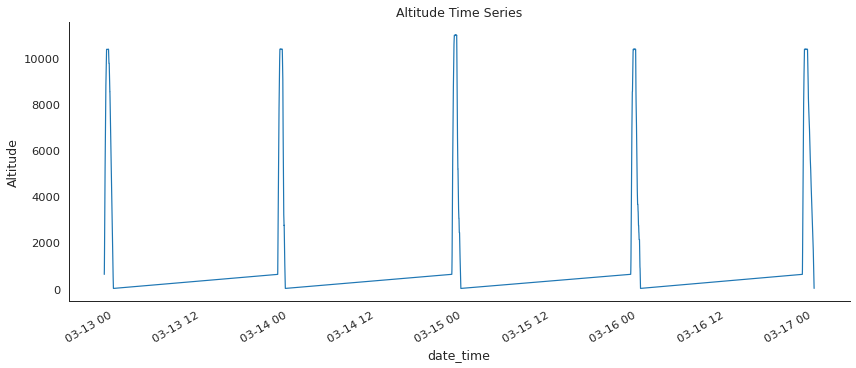

In [43]:
dfspec=df_update.loc[:,['date_time','meters']]
dfspec.set_index('date_time',inplace=True)
dfspec.plot(figsize=(12,5))
plt.ylabel('Altitude')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Altitude Time Series')
sns.despine(top=True)
plt.show();

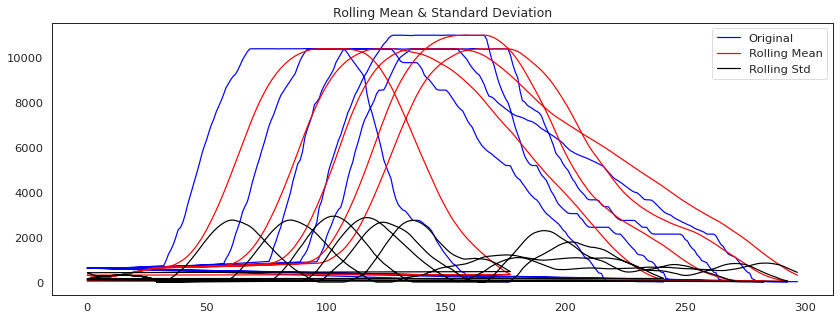

<Results of Dickey-Fuller Test>
Test Statistic                  -4.6252
p-value                          0.0001
#Lags Used                       7.0000
Number of Observations Used   1288.0000
Critical Value (1%)             -3.4354
Critical Value (5%)             -2.8638
Critical Value (10%)            -2.5680
dtype: float64


In [44]:
df2=df_update.copy()
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.meters)

In [45]:
dataset = df_update.meters.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
test_size = dataframelist[-1].shape[0]
train_size = len(dataset) - test_size
train, test = dataset[:train_size,:], dataset[train_size:,:]

def create_dataset(dataset, look_back, look_ahead):
    X, Y = [], []
    for i in range(len(dataset)-look_back-look_ahead):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back + look_ahead - 1, 0])
    return np.array(X), np.array(Y)
    
look_back = 5
look_ahead = 1
X_train, Y_train = create_dataset(train, look_back, look_ahead)
X_test, Y_test = create_dataset(test, look_back, look_ahead)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [46]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1, shuffle=False)

model.summary()

Epoch 1/15
31/31 [==============================] - 3s 23ms/step - loss: 0.1785 - val_loss: 0.0745
Epoch 2/15
31/31 [==============================] - 0s 5ms/step - loss: 0.0350 - val_loss: 0.0093
Epoch 3/15
31/31 [==============================] - 0s 5ms/step - loss: 0.0101 - val_loss: 0.0057
Epoch 4/15
31/31 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0035
Epoch 5/15
31/31 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 6/15
31/31 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 7/15
31/31 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 8/15
31/31 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 9/15
31/31 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 10/15
31/31 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 11/15
31/31 

In [47]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

10/10 [==============================] - 0s 2ms/step
Train Mean Absolute Error: 270.9191445420148
Train Root Mean Squared Error: 444.4492428586986
Test Mean Absolute Error: 200.11332618951892
Test Root Mean Squared Error: 386.83655643099047


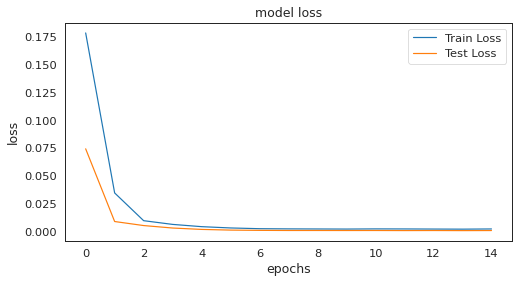

In [48]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

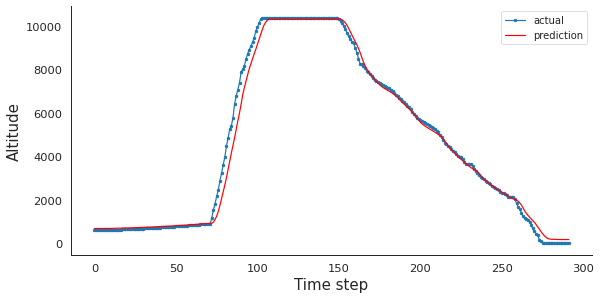

In [49]:
aa=[x for x in range(Y_test.shape[1])]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:][:,0], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Altitude', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show();